## Insect Image Embeddings Workshop (🐞)
Iman Mossavat

### Workshop Goal
AI is increasingly used to monitor and protect biodiversity, from classifying species to tracking ecosystem health. At Fontys, we have ongoing projects using AI to help identify and catalog insect species. One of the most fundamental AI concepts enabling this is **embeddings**, which map images and text into a shared space where similarity can be measured.

In this workshop, our goal is to use a pre-trained model from OpenAI, **CLIP**, to identify insects. Students will explore how images of insects can be embedded and semantically compared, allowing similarity search between images and textual descriptions.

### Kaggle Dataset
We'll use a **lighter dataset with agricultural pest images**:
https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset

This dataset contains JPEG images of pests with labels indicating the insect type.

---

## 🔑 Step 1: Get Your Kaggle API Key

To download the dataset from Kaggle into Google Colab, you need a Kaggle API key. Think of it like your personal password for Kaggle that Python can use.

Instructions

Log into Kaggle

Go to https://www.kaggle.com/

Click Sign In (top right) and enter your account details.

Go to your Account Settings

Find the API section and "Create New API Token".

Download kaggle.json

Kaggle will download a file called kaggle.json to your computer.

This file contains your username and secret key.

# Getting the data

This code sets up Google Colab so you can download datasets directly from Kaggle. First, it installs the Kaggle API (a tool for accessing Kaggle data). Then, it uploads your personal API key (kaggle.json) so Colab can authenticate with Kaggle. Finally, it uses the API to download the Spotify dataset and unzip it, making the data ready for analysis in your notebook.

In [ ]:
# Install Kaggle API and download dataset (Colab)
!pip install kaggle


# Install official OpenAI CLIP
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pzvukkuz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pzvukkuz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import os
from google.colab import drive, files

# 1️⃣ Mount Google Drive
if not os.path.exists("/content/drive/MyDrive"):
    drive.mount('/content/drive')

# 2️⃣ Set paths
kaggle_json_drive = "/content/drive/MyDrive/kaggle/kaggle.json"
kaggle_json_local = os.path.expanduser("~/.kaggle/kaggle.json")
dataset_dir = "/content/drive/MyDrive/kaggle/agricultural-pests-dataset"
zip_file = os.path.join(dataset_dir, "Agricultural Pests Image Dataset.zip")

# 3️⃣ Ensure kaggle.json is in ~/.kaggle
if not os.path.exists(kaggle_json_local):
    if os.path.exists(kaggle_json_drive):
        os.makedirs(os.path.dirname(kaggle_json_local), exist_ok=True)
        !cp "{kaggle_json_drive}" "{kaggle_json_local}"
        !chmod 600 "{kaggle_json_local}"
        print("kaggle.json copied from Drive.")
    else:
        print("kaggle.json not found in Drive. Please upload it:")
        files.upload()
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

# 4️⃣ Download dataset only if not already present
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)
    !kaggle datasets download -d vencerlanz09/agricultural-pests-image-dataset -p "{dataset_dir}"
    print("Dataset downloaded.")
else:
    print(f"Dataset folder already exists at {dataset_dir}.")

# 5️⃣ Unzip the dataset if not already unzipped
unzipped_flag = os.path.join(dataset_dir, "Agricultural Pests Image Dataset")
if not os.path.exists(unzipped_flag):
    zip_files = [f for f in os.listdir(dataset_dir) if f.endswith(".zip")]
    if zip_files:
        zip_file_path = os.path.join(dataset_dir, zip_files[0])
        !unzip -o "{zip_file_path}" -d "{dataset_dir}"
        print("Dataset unzipped.")
    else:
        print("No ZIP file found to unzip.")
else:
    print("Dataset already unzipped and ready to use.")


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/ants/ants (96).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/ants/ants (97).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/ants/ants (98).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/ants/ants (99).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/bees/bees (1).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/bees/bees (10).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/bees/bees (100).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/bees/bees (101).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/bees/bees (102).jpg  
  inflating: /content/drive/MyDrive/kaggle/agricultural-pests-dataset/bees/bees (103).jpg  
  inflating: /content/drive/MyDrive/

# Step 1: Explore the Dataset


In [ ]:
# Step 2: Load Libraries and CLIP
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

# Set device and load CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [ ]:
# Step 3: Prepare Dataset Metadata (adjusted for your folder structure)
import os

dataset_path = "/content/drive/MyDrive/kaggle/agricultural-pests-dataset"

# Check what’s inside this folder
print("📁 Contents of dataset directory:", os.listdir(dataset_path))

# Gather images and labels (each subfolder is a pest type)
image_paths, labels = [], []

for subdir in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, subdir)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(folder_path, img_file))
                labels.append(subdir)

print(f"✅ Total images found: {len(image_paths)}")
print(f"🦋 Insect types detected: {set(labels)}")


📁 Contents of dataset directory: ['agricultural-pests-image-dataset.zip', 'ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']
✅ Total images found: 5494
🦋 Insect types detected: {'grasshopper', 'bees', 'moth', 'snail', 'earwig', 'earthworms', 'slug', 'wasp', 'catterpillar', 'beetle', 'weevil', 'ants'}


### How CLIP Understands and Compares Images and Text

Now that we have some insect (or pest) images and their labels, we’ll use CLIP to see **how similar** each image is to its possible text descriptions.

1. **Encoding (Turning into numbers)**
   CLIP takes both an image and a text (like “aphid” or “grasshopper”) and turns them into *embeddings* — lists of numbers that represent the meaning of the image or text.

2. **Normalizing**
   We then “normalize” these embeddings so they all have the same length. This makes it fair to compare them.

3. **Comparing Similarity**
   We measure how close each image’s embedding is to each text’s embedding using **cosine similarity**.

   * If the image and text are similar (e.g., a photo of a beetle and the word “beetle”), their embeddings point in nearly the same direction — giving a high similarity score.
   * If they’re different (e.g., a photo of a moth and the word “ant”), the score is lower.

4. **Prediction**
   The model picks the label with the highest similarity score as its best guess for what’s in the image.

5. **Visualization**
   Finally, we show each image with the predicted and true labels — so you can see how well CLIP understands your insects!



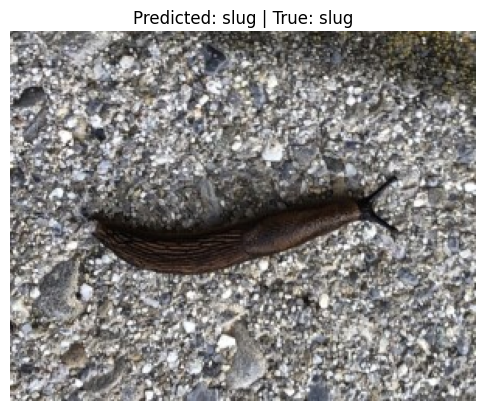

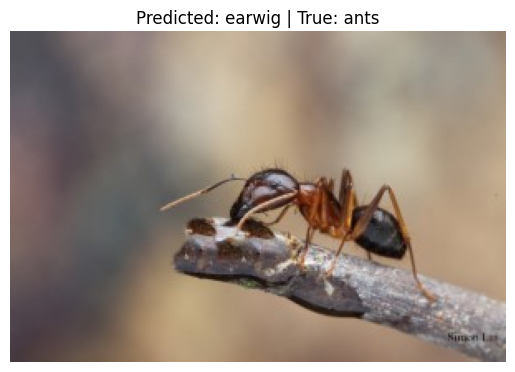

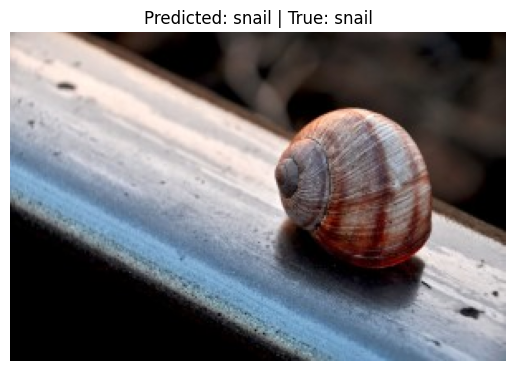

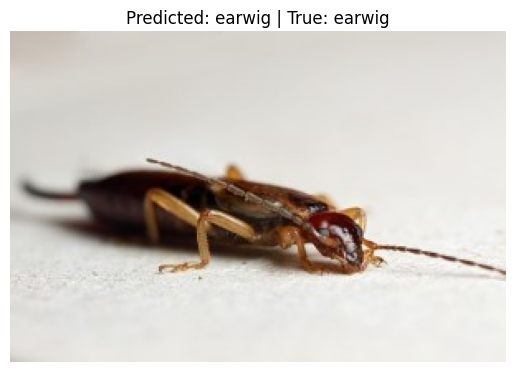

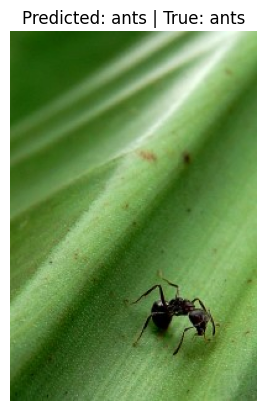

In [ ]:
# Step 5: Encode Images and Text Labels with CLIP
sample_indices = random.sample(range(len(image_paths)), 5)
sample_images = [image_paths[i] for i in sample_indices]
sample_labels = [labels[i] for i in sample_indices]

image_embeddings = []
for img_path in sample_images:
    img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)
        image_embeddings.append(emb)

text_tokens = clip.tokenize(sample_labels).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

# Step 6: Compute Similarities and Show Predictions
for i, img_emb in enumerate(image_embeddings):
    sims = F.cosine_similarity(img_emb, text_embeddings)
    best_idx = sims.argmax()
    img = Image.open(sample_images[i])
    plt.imshow(img)
    plt.title(f"Predicted: {sample_labels[best_idx]} | True: {sample_labels[i]}")
    plt.axis('off')
    plt.show()



# Experiment Ideas
# 1. Pick a specific pest (e.g., aphid) and see how the model predicts it.
# 2. Explore images with different backgrounds or crops and see how embeddings handle it.
# 3. Add your own text captions and find which images they match best.
# 4. Visualize embeddings with PCA or t-SNE to see clusters of pest types.
# 5. Optional: Try clustering embeddings with KMeans to group visually similar pests.